# Small Test

I am interested in fitting an ode (i.e a vector-valued function with multiple outputs).

See [here](https://symfit.readthedocs.io/en/latest/fitting_types.html#:~:text=won%E2%80%99t%20work%20otherwise.-,ODE%20Fitting,-Fitting%20to%20a) and [here](https://symfit.readthedocs.io/en/latest/fitting_types.html#:~:text=it%20with%20.x.-,Fitting%20multiple%20datasets,-A%20common%20fitting) for examples of what I want to do. These links use a package called symfit. I'd like to see if scipy can do it. If not, I'll try it. Or a package called lmfit [here](https://lmfit.github.io/lmfit-py/faq.html#:~:text=return%20resid.flatten()-,How%20can%20I%20fit%20multiple%20data%20sets%3F,-%C2%B6) seems to have some suggestions as well for how to do this.

Essentially I'm trying to fit several data sets at the same time that share parameters.

### Random Example from Online

 Best-Fit Parameters:  [-0.78840852  1.69464348  5.93174396 50.1259702 ]


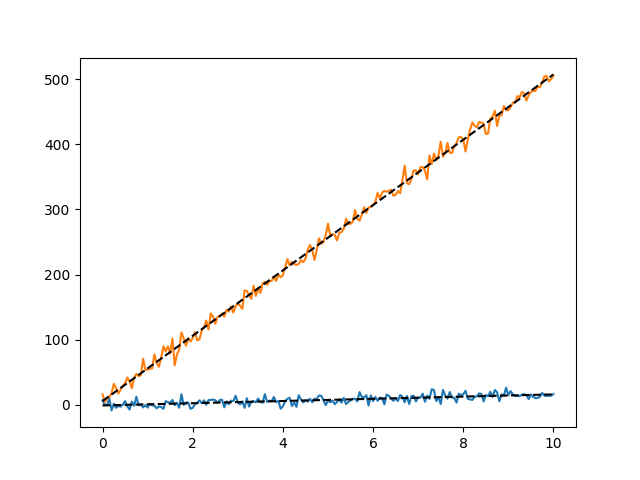

In [33]:
import numpy as np
from scipy.optimize import leastsq

def residual_two_functions(pars, x, y1, y2):
    off1   = pars[0]
    slope1 = pars[1]
    off2   = pars[2]
    slope2 = pars[3]
    diff1 = y1 - (off1 + slope1 * x)
    diff2 = y2 - (off2 + slope2 * x)
    return np.concatenate((diff1, diff2))

# create two tests data sets
NPTS = 201
x  = np.linspace(0, 10, NPTS)
y1 = -0.7 +  1.7*x + np.random.normal(scale=5, size=NPTS)
y2 =  5.2 + 50.1*x + np.random.normal(scale=9, size=NPTS)

# initial values 
par_init = np.array([1, 1, 1, 1])

best, cov, info, message, ier = leastsq(residual_two_functions,
                                        par_init, args=(x, y1, y2),
                                        full_output=True)

print(" Best-Fit Parameters: ",  best)

plt.clf()
plt.plot(x, y1)
plt.plot(x, y2)

plt.plot(x, best[0] + best[1]*x, '--k')
plt.plot(x, best[2] + best[3]*x, '--k')
plt.show()


### Generate Data

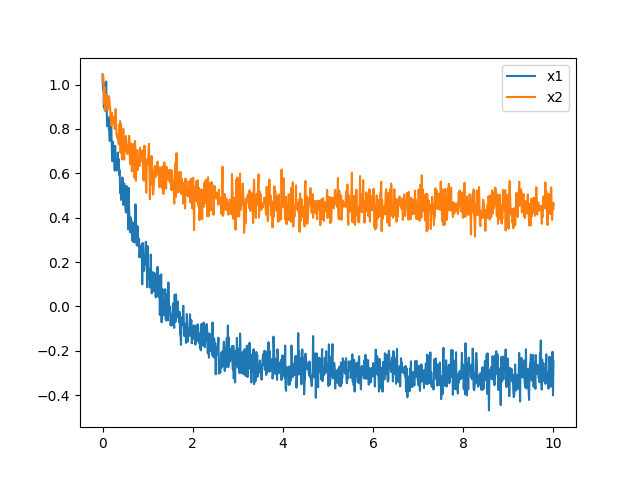

In [34]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib widget

def derivs(t:float,x:np.ndarray,k:float, c1:float, c2:float)->np.ndarray:
    x1 = x[0]
    x2 = x[1]
    #some coupled first order ode with 2 outputs
    return np.array([-k*x1 + c1, -k*x2**2 + c2]) 

def generateData(tspan:tuple, k, c1, c2) -> tuple:
    #forward simulate ode over tspan
    sol = solve_ivp(derivs, t_span=tspan, y0=np.array([1.,1.]), args=(k,c1,c2), max_step=.01)

    #add noise to 2 output variables that I am trying to fit
    x1 = sol.y[0,:] + np.random.normal(0, .05, size=sol.y[0,:].shape)
    x2 = sol.y[1,:] + np.random.normal(0, .05, size=sol.y[0,:].shape)


    #maybe throw in some outliers

    return (sol.t,x1,x2)

t,x1,x2 = generateData((0,10), 1, -.3, .2)
plt.plot(t,x1, label='x1')
plt.plot(t,x2, label='x2')
plt.legend()



Now that I've generated 'real' time-series data, I assume that all I know is the form of the model, but that the parameters k, c1, and c2 are unknown. The form the the model is

$$ 
\begin{align*}
\dot{x}_1 &= -kx_1 + c_1\\
\dot{x}_2 &= -kx_2^2 + c_2
\end{align*}
$$

[Scipy Least Squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares)

[Example of fitting multiple datasets](https://stackoverflow.com/questions/23532068/fitting-multiple-data-sets-using-scipy-optimize-with-the-same-parameters)

In [23]:
# from scipy.optimize import curve_fit
from scipy.optimize import least_squares

#nonlinear least squares, 2 output values (m), 3 input parameters (n)
#f needs to return a 1d array of shape (m,) of residuals given a 1d array of shape (n,)
#what is vector of residuals that I need to return? it needs to be a (2,) vector.
def f(p):
    k=p[0]
    c1=p[1]
    c2=p[2]

    tspan = (0,10)
    sol = solve_ivp(derivs, t_span=tspan, y0=np.array([1.,1.]), args=(k,c1,c2), max_step=.01)
    return 

# p_opt, p_cov = curve_fit(f, xdata, ydata, p0)

#n dim initial guess
p0 = np.ones(3)

x = least_squares(f, p0, loss='linear',verbose=1)

ValueError: `fun` must return at most 1-d array_like. f0.shape: (2, 1005)

# Utilities

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm
import pandas as pd


#utility functions
def absPressure(p):
    return p + 14.75  

def gaugePressure(p):
    return p - 14.75

def pascals(p):
    return p * 6895.

def psi(p):
    return p/6895.

def psig(p):
    #expects pressure in absolute pascals
    return gaugePressure(psi(p))

def pascals_abs(p):
    #expects pressure in psig
    return pascals(absPressure(p))

# Data Loading

In [2]:
#load data
data = pd.read_csv('./constant_volume_step_data.csv')

sub = 100
#extract area commands and times
time_data = data['Time'][:].iloc[::sub]
area_cmds = data['Orifice Command'][:].iloc[::sub]
pressure_data = data['Pressure (psi)'][:].iloc[::sub]

data.head()

,Unnamed: 0,Unnamed: 0.1,Time,Pressure (psi),Valve Command,Current Command,Orifice Command
0,0,0,0.000000,0.18,0.0,-0.00194,-0.000366
1,1,1,0.000775,0.32,0.0,-0.00194,-0.000366
2,2,2,0.001574,0.42,0.0,-0.00194,-0.000366
3,3,3,0.002350,0.49,0.0,-0.00194,-0.000366
4,4,4,0.003126,0.51,0.0,-0.00194,-0.000366


# Analytical Model

In [3]:
def calc_plant_derivs(t,p,area,params):
    C_fill,C_vent = params
    M,T,R = .029, 295, 8.31
    Z,k =  .99, 1.4
    #constants, see appendix of Tassa paper 
    theta = ((k+1)/2)**(k/(k-1))
    Psrc = pascals(absPressure(55))
    Patm = pascals(absPressure(0))
    #physical constants
    V = .0004
    
    #NOTE: p comes in as absolute pressure


    #switching function for choked/unchoked flow
    def z(Pu, Pd):
        if Pu/Pd <= theta:
            # print('plant nonlinearity: ', np.sqrt((Pd/Pu)**(2/k) - (Pd/Pu)**((k+1)/k)))
            # print("UNCHOKED FLOW", Pu/Pd)
            return alpha*Pu * np.sqrt((Pd/Pu)**(2/k) - (Pd/Pu)**((k+1)/k))
        else:
            # print("CHOKED FLOW", Pu/Pd)
            return beta*Pu

    #switching function for direction of mass flow
    def phi(Pu,Pd):
        if Pu >= Pd:
            # print("FILL")
            return z(Pu,Pd)
        else:
            # print("VENT")
            return -z(Pd,Pu)

    a = area
    #valve cannot vent and fill at same time
    if a >= 0:
        #fill, from compressor to chamber
        alpha = C_fill * np.sqrt((2*M*k)/(Z*R*T*(k-1)))
        beta = C_fill * np.sqrt(((k*M)/(Z*R*T)) * (2/(k+1))**((k+1)/(k-1)))
        ac = a
        ar = 0
        mdot = ac*phi(Psrc, p)
    elif a < 0:
        #vent, from chamber to atm
        alpha = C_vent * np.sqrt((2*M*k)/(Z*R*T*(k-1)))
        beta = C_vent * np.sqrt(((k*M)/(Z*R*T)) * (2/(k+1))**((k+1)/(k-1)))
        ac = 0
        ar = np.abs(a) #positive area
        mdot = - ar*phi(p, Patm)

    pdot = k*R*T*mdot/V - 0 # zero for ignoring volume

    return pdot

In [4]:
from tqdm import tqdm
def simulate(params):
    pressure_hist = []
    pressure_hist.append(pascals(absPressure(pressure_data[0])))
    p0 = pressure_hist[0]
    for i in tqdm(range(len(time_data)-1)):
        tspan = (time_data[i*sub], time_data[(i+1)*sub])
        area = area_cmds[i*sub] * 2.5e-5
        sol  = solve_ivp(calc_plant_derivs, tspan, np.array([p0]), args=(area,params))
        p0 = sol.y.flatten()[-1]
        pressure_hist.append(p0)

    return np.array(pressure_hist)

In [8]:
params = (.7, .7) #Cfill Cvent Z k
sim_pressure = simulate(params)


100%|██████████| 3126/3126 [00:00<00:00, 4656.58it/s]


Text(0.5, 0, 'Time (s)')

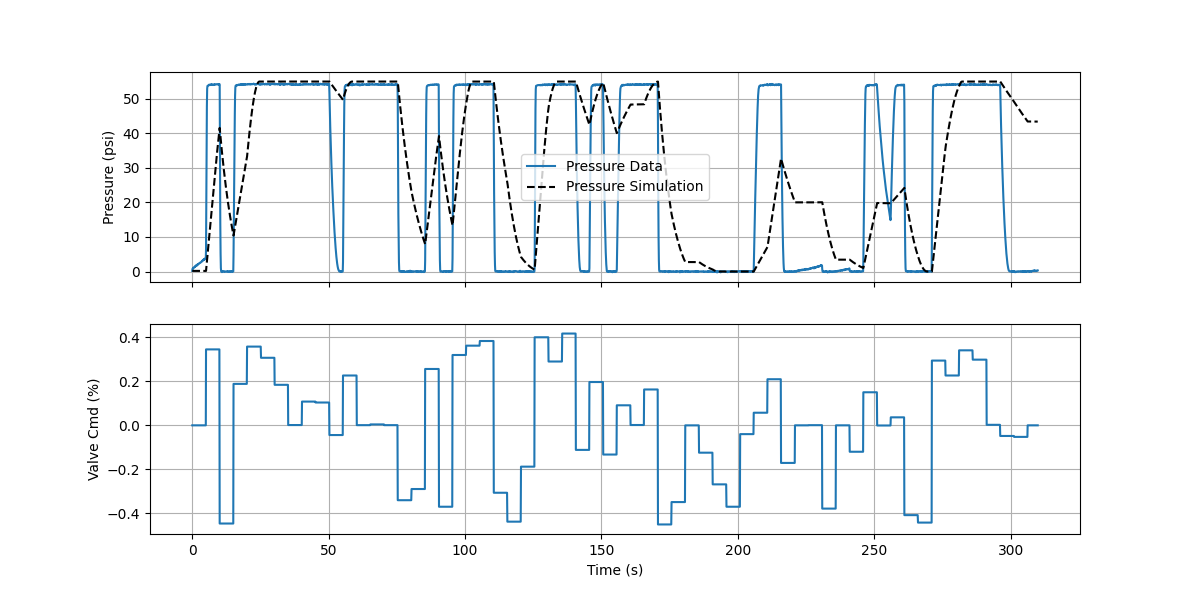

In [19]:
%matplotlib widget
fig, ax = plt.subplots(2,1,sharex=True, figsize=(12,6))
ax[0].plot(time_data, pressure_data, label="Pressure Data")
ax[0].plot(time_data, gaugePressure(psi(sim_pressure)), '--k', label="Pressure Simulation")
ax[0].legend().set_draggable(True)
ax[0].set_ylabel("Pressure (psi)")
ax[0].grid(True)
ax[1].plot(time_data, area_cmds, label='Orifice Area')
ax[1].grid(True)
ax[1].set_ylabel('Valve Cmd (%)')
ax[1].set_xlabel('Time (s)')


In [24]:
#optimize 
def objective(params):
    sim_pressure = simulate(params)
    sim_pressure = gaugePressure(psi(sim_pressure))

    #calculate objective, normalized sse
    error = sim_pressure-np.array(pressure_data)
    # obj = np.sum(error**2)
    obj = np.sum(np.abs(error))

    # import pdb; pdb.set_trace()
    print(obj)

    return obj/len(error)

In [25]:
from scipy.optimize import minimize
#initial parameter guesses
params = (.7, .7) #Cfill Cvent Z k
bnds = ((.5,1), (.5,1))

solution = minimize(objective, params, method='SLSQP', bounds=bnds, options={'disp':True, 'maxiter':25})

100%|██████████| 3126/3126 [00:00<00:00, 4859.03it/s]


46141.200574794784


100%|██████████| 3126/3126 [00:00<00:00, 4956.29it/s]


46141.200444309296


100%|██████████| 3126/3126 [00:00<00:00, 5090.86it/s]


46141.200377517904


100%|██████████| 3126/3126 [00:00<00:00, 4936.06it/s]


40856.38059167177


100%|██████████| 3126/3126 [00:00<00:00, 4832.30it/s]


40856.380665836725


100%|██████████| 3126/3126 [00:00<00:00, 4586.27it/s]

40856.38073852561
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.06567975429222
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2


In [26]:
print(solution)


     fun: 13.06567975429222
     jac: array([-1.59166157, -3.15164506])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1., 1.])


In [27]:
final_sim_pressure = simulate(tuple(solution.x))

100%|██████████| 3126/3126 [00:00<00:00, 4587.40it/s]


Text(0, 0.5, 'Valve Cmd (%)')

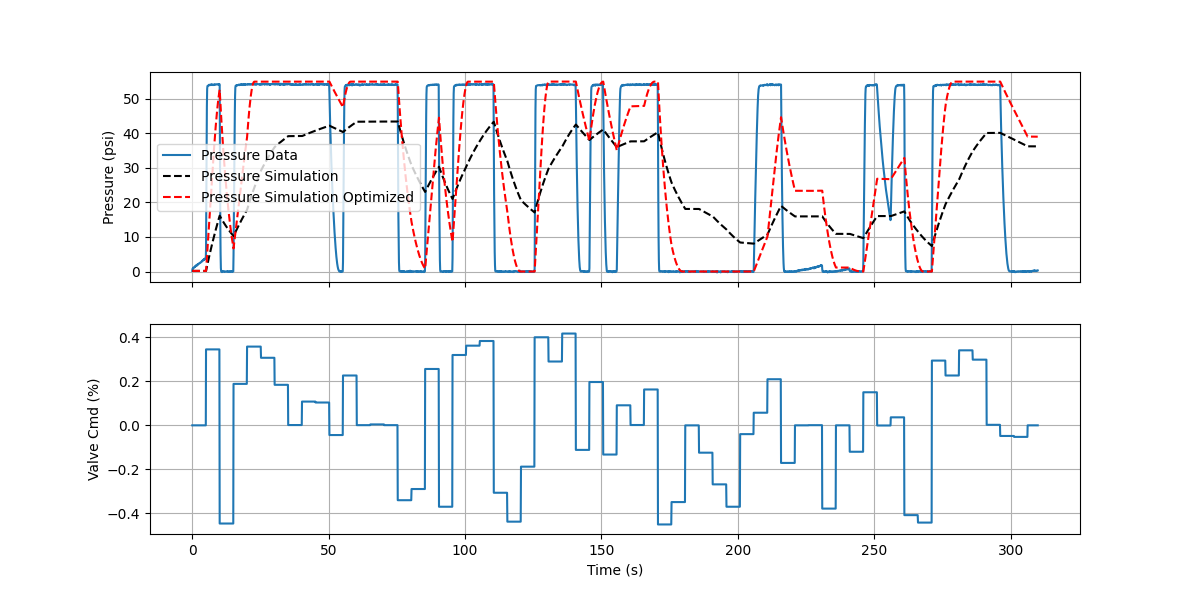

In [45]:
fig, ax = plt.subplots(2,1,sharex=True, figsize=(12,6))
ax[0].plot(time_data, pressure_data, label="Pressure Data")
ax[0].plot(time_data, gaugePressure(psi(sim_pressure)), '--k', label="Pressure Simulation")
ax[0].plot(time_data, gaugePressure(psi(final_sim_pressure)), '--r', label="Pressure Simulation Optimized")
ax[0].legend().set_draggable(True)
ax[0].set_ylabel('Pressure (psi)')
ax[0].grid(True)
ax[1].plot(time_data, area_cmds, label='Orifice Area')
ax[1].grid(True)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Valve Cmd (%)')

Well, this model is really not working that great... It's too slow. It looks really great if I let parameters have nonphysical values... so not sure there. So what if I use Tassa's parameterized version?

# First Order Model

$$ \tau \dot{p} = K A a(i) f(p) $$

where 

$$
\begin{equation}
  f(p) =
    \begin{cases}
      P_{src} - p, \quad a(i) \geq 0 \\
      p - P_{atm}, \quad a(i) < 0 \\
    \end{cases}       
\end{equation}
$$

Let $\beta = K/ \tau$. Then $\dot{p} =  \beta A a(i) f(p)$.

A: max valve area (m^2)

K: gain (1/m^2)

p: Pa

a(i): percentage open as a function of current (i).



In [40]:
Psrc = pascals_abs(55)
Patm = pascals_abs(0)
print(Psrc)
print(Patm)
def calc_plant_derivs_FO(t,p,area,params):
    #given p in same units as Psrc and Patm
    tau = params
    K = 1/2.5e-5
    beta = K/tau 
    A = 2.5e-5

    #since k and tau both affect same thing, I'm really only optimizing beta.
    # I can't really get at individual tau and K values... Can I just set K = 1?

    #filling vs venting
    if area < 0:
        #vent
        return beta*A*area*(p - Patm)
    else:
        #fill
        return beta*A*area*(Psrc - p)


480926.25
101701.25


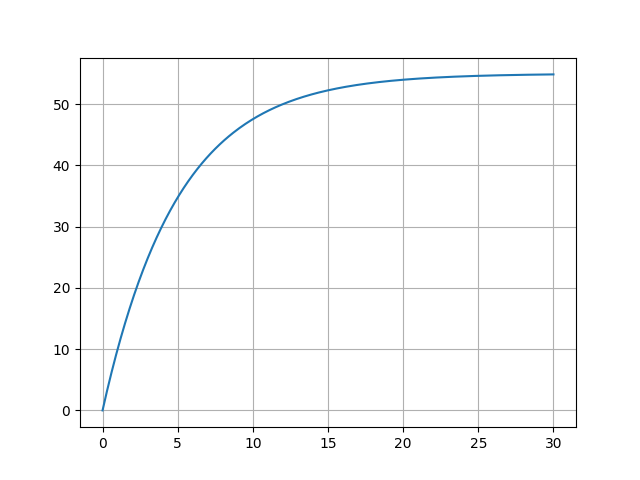

In [41]:
# p0 = pascals(absPressure(0))
p0 = pascals_abs(0)
area = 1
params =  (5) #K/tau
sol  = solve_ivp(calc_plant_derivs_FO, t_span=(0,30), y0=np.array([p0]), args=(area,params), max_step = .1)
plt.figure()
plt.plot(sol.t, psig(sol.y.flatten()))
plt.grid(True)
plt.show()

In [42]:
def simulate_FO(params):
    #pressure_hist in absolute pascals
    pressure_hist = []
    pressure_hist.append(pascals_abs(pressure_data[0]))
    #need pressures to be in abs pa
    p0 = pressure_hist[0]
    for i in tqdm(range(len(time_data)-1)):
        tspan = (time_data[i*sub], time_data[(i+1)*sub])
        area = area_cmds[i*sub]
        sol  = solve_ivp(calc_plant_derivs_FO, tspan, np.array([p0]), args=(area,params))
        p0 = sol.y.flatten()[-1]
        pressure_hist.append(p0)

    return np.array(pressure_hist)

100%|██████████| 3126/3126 [00:00<00:00, 9229.22it/s]


Text(0.5, 0, 'Time (s)')

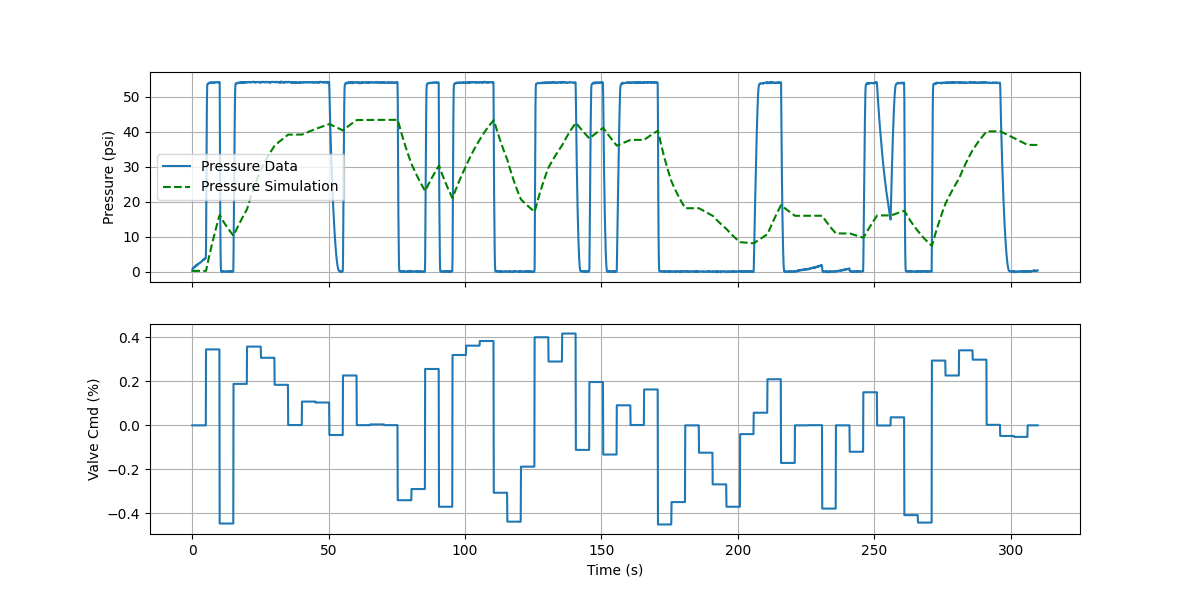

In [48]:
params = (5.) #tau
sim_pressure = simulate_FO(params)
%matplotlib widget
fig, ax = plt.subplots(2,1,sharex=True, figsize=(12,6))
ax[0].plot(time_data, pressure_data, label="Pressure Data")
ax[0].plot(time_data, psig(sim_pressure), '--g', label="Pressure Simulation")
ax[0].legend().set_draggable(True)
ax[0].set_ylabel('Pressure (psi)')
ax[0].grid(True)
ax[1].plot(time_data, area_cmds, label='Orifice Area')
ax[1].grid(True)
ax[1].set_ylabel('Valve Cmd (%)')
ax[1].set_xlabel('Time (s)')


In [49]:
def normalize(data):
    #normalizes data between 0 and 1
    return (data - np.min(data)) / (np.max(data) - np.min(data))

#optimize 
def objective2(params):
    sim_pressure = simulate_FO(params)
    sim_pressure = psig(sim_pressure)

    #calculate objective, normalized sse
    error = sim_pressure-np.array(pressure_data)
    # obj = np.sum(error**2)
    obj = np.sum(np.abs(error))

    # import pdb; pdb.set_trace()
    # print(obj)

    #scale this down a bit...
    return obj/len(error)

In [8]:
#experiment tracking
import wandb

In [50]:
from scipy.optimize import Bounds
params = (0.5)
bnds = Bounds(.01, 0.5)
optimizer='SLSQP'
max_iter = 25

# config = {
#   "bounds": bnds,
#   "starting_param": params,
#   "optimizer": optimizer,
#   'max_iterations': max_iter,
#   'loss':'Absolute Error'
# }
# run = wandb.init(project="first-order-pressure_model", entity="curtiscjohnson", config=config)

# def callback(x):
#     #log stuff
#     wandb.log({
#         'current_param':x,
#         'loss':objective2(x)
#     })

def callback(x):
  pass

solution = minimize(objective2, params, method=optimizer, bounds=bnds, options={'disp':True, 'maxiter':max_iter}, callback=callback)
print(solution.x)

100%|██████████| 3126/3126 [00:00<00:00, 4193.75it/s]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1665198349124852
            Iterations: 8
            Function evaluations: 17
            Gradient evaluations: 8
[0.05382756]


In [51]:
final_sim_pressure2 = simulate_FO(solution.x)

100%|██████████| 3126/3126 [00:00<00:00, 4165.88it/s]


NameError: name 'wandb' is not defined

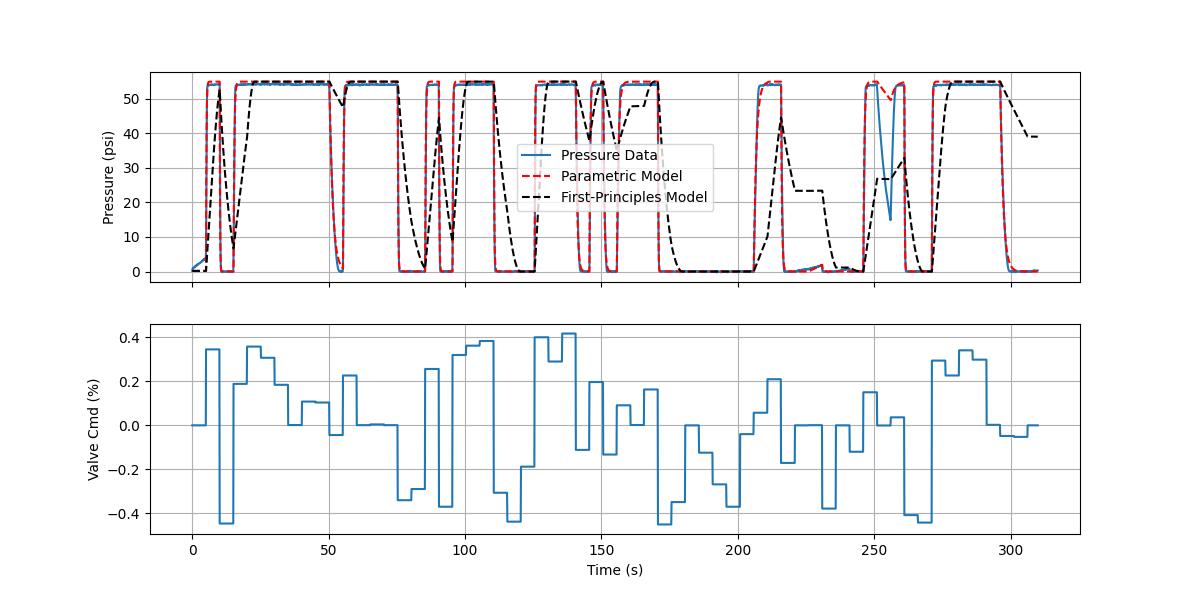

In [58]:
fig, ax = plt.subplots(2,1,sharex=True, figsize=(12,6))
ax[0].plot(time_data, pressure_data, label="Pressure Data")
ax[0].plot(time_data, psig(final_sim_pressure2), '--r', label="Parametric Model")
ax[0].plot(time_data, psig(final_sim_pressure), '--k', label="First-Principles Model")
ax[0].legend().set_draggable(True)
ax[0].grid(True)
ax[0].set_ylabel('Pressure (psi)')
ax[1].plot(time_data, area_cmds, label='Orifice Area')
ax[1].grid(True)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Valve Cmd (%)')

img = plt.savefig('sim.png')
wandb.log({'optimized_results':wandb.Image('sim.png')})


In [13]:
run.finish()

NameError: name 'run' is not defined

# GEKKO MHE on First Order Model

In [53]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random
from gekko import GEKKO


# Make an MP4 animation?
make_mp4 = False
if make_mp4:
    import imageio  # required to make animation
    import os
    try:
        os.mkdir('./figures')
    except:
        pass


#get input trajectory from data, area_cmds variable
# number data point
n = len(time_data)

# Record initial pressure
Pm = pascals_abs(pressure_data[0]) * np.ones(n)

# Store MHE values for plots
P_mhe = Pm[0] * np.ones(n)
tau_mhe = 1. * np.ones(n)

#########################################################
# Initialize Model as Estimator
#########################################################
m = GEKKO(name='pressure-mhe',remote=False)

# 5 second time horizon, 200 steps (.01 dt)
m.time = np.linspace(0,2,201)

# Parameters to Estimate
tau = m.FV(value=1.0,lb=.001, ub = 5, name='tau')   # W / % heater
tau.STATUS = 1  # don't estimate initially
tau.FSTATUS = 0 # no measurements
# tau.DMAX = 0.001
# tau.LOWER = 0.003
# tau.UPPER = 0.03

# Measured inputs
a = m.MV(value=0, lb=-1, ub=1, name='area')
a.STATUS = 0  # don't estimate
a.FSTATUS = 1 # receive measurement

# Measurements for model alignment - pressures
P = m.CV(value=Pm[0],name='P')
P.STATUS = 1     # minimize error between simulation and measurement
P.FSTATUS = 1    # receive measurement
# P.MEAS_GAP = 0.1 # measurement deadband gap
# P.LOWER = 0
# P.UPPER = 200

#Certain parameters
A = m.Param(value=2.5e-5) #maximum valve orifice area
Psrc = m.Param(value=pascals_abs(55))
Patm = m.Param(value=pascals_abs(0))


# Equations of motion
# f = x1 when condition < 0 and f = x2 when condition >=0
# f = m.if3(condition,x1,x2)
# in my case, the condition is the orifice percentage command (-1,1).
# when a < 0, I want f to be (p-patm). When a >=0, I want f to be (Psrc - P).
fill = m.Intermediate(Psrc - P)
vent = m.Intermediate(P - Patm)

#I CANNOT GET THIS BLASTED THING TO WORK!!! NEGATIVE DEGREES OF FREEDOM ALL THE TIME.
f = m.if3(a, vent, fill)
m.Equation(P.dt() == (A*a*f)/tau)

# Global Options
m.options.IMODE   = 5 # MHE
m.options.EV_TYPE = 2 # Objective type
m.options.NODES   = 3 # Collocation nodes
m.options.SOLVER  = 1 # APOPT needed for if3
m.options.COLDSTART = 1 # COLDSTART on first cycle
##################################################################


from tqdm import tqdm

# Main Loop
for i in tqdm(range(1,n)):
    # Read pressure in absolute pascals from data
    Pm[i] = pascals_abs(pressure_data[i*sub])

    # Insert measurement
    P.MEAS = Pm[i]

    # Insert Inputs from data
    a.MEAS = area_cmds[(i-1)*sub]

    # # Start estimating U after 10 cycles 
    # if i==10:
    #     tau.STATUS = 1

    # Predict Parameters and Pressure with MHE
    m.solve(disp=False) 

    if m.options.APPSTATUS == 1:
        # Retrieve new values
        P_mhe[i] = P.MODEL
        tau_mhe[i]  = tau.NEWVAL
    else:
        # Solution failed, copy prior solution
        P_mhe[i] = P_mhe[i-1]
        tau_mhe[i]  = tau_mhe[i-1]

#     # Plot
#     plt.clf()
#     ax=plt.subplot(3,1,1)
#     ax.grid()
#     plt.plot(tm[0:i],T1m[0:i],'ro',label=r'$T_1$ measured')
#     plt.plot(tm[0:i],Tmhe1[0:i],'k-',label=r'$T_1$ MHE')
#     plt.plot(tm[0:i],T2m[0:i],'bx',label=r'$T_2$ measured')
#     plt.plot(tm[0:i],Tmhe2[0:i],'k--',label=r'$T_2$ MHE')
#     plt.ylabel('Temperature (degC)')
#     plt.legend(loc=2)
#     ax=plt.subplot(3,1,2)
#     ax.grid()
#     plt.plot(tm[0:i],Umhe[0:i],'k-',label='Heat Transfer Coeff')
#     plt.plot(tm[0:i],amhe1[0:i]*1000,'r--',label=r'$\alpha_1$x1000')
#     plt.plot(tm[0:i],amhe2[0:i]*1000,'b--',label=r'$\alpha_2$x1000')
#     plt.ylabel('Parameters')
#     plt.legend(loc='best')
#     ax=plt.subplot(3,1,3)
#     ax.grid()
#     plt.plot(tm[0:i],Q1s[0:i],'r-',label=r'$Q_1$')
#     plt.plot(tm[0:i],Q2s[0:i],'b:',label=r'$Q_2$')
#     plt.ylabel('Heaters')
#     plt.xlabel('Time (sec)')
#     plt.legend(loc='best')
#     plt.draw()
#     plt.pause(0.05)
#     if make_mp4:
#         filename='./figures/plot_'+str(i+10000)+'.png'
#         plt.savefig(filename)


# # generate mp4 from png figures in batches of 350
# if make_mp4:
#     images = []
#     iset = 0
#     for i in range(1,n):
#         filename='./figures/plot_'+str(i+10000)+'.png'
#         images.append(imageio.imread(filename))
#         if ((i+1)%350)==0:
#             imageio.mimsave('results_'+str(iset)+'.mp4', images)
#             iset += 1
#             images = []
#     if images!=[]:
#         imageio.mimsave('results_'+str(iset)+'.mp4', images)


  0%|          | 0/3126 [00:00<?, ?it/s]


Exception: @error: Degrees of Freedom
 * Error: DOF must be zero for this mode
 STOPPING...


# My Own MHE, since GEKKO is dumb

At each time point:

1) take in pressure data from a receding time window of some horizon length
2) Optimize tau based on the error between the current model prediction, and the data in the buffer
3) update model parameter with optimized tau.

In [59]:
print(np.diff(time_data))

[0.07828188 0.07826066 0.07831883 ... 0.07829094 0.07826185 0.07830715]


In [60]:
time_data

0           0.000000
100         0.078282
200         0.156543
300         0.234861
400         0.313371
             ...    
312200    309.605557
312300    309.683890
312400    309.762181
312500    309.840443
312600    309.918750
Name: Time, Length: 3127, dtype: float64

In [61]:
def simulate_mhe(param, p0, input_buffer, time_buffer):
    #pressure_hist in absolute pascals
    pressure_hist = []
    pressure_hist.append(p0)
    #need pressures to be in abs pa
    p0 = pressure_hist[0]
    for i in range(len(time_buffer)-1):
        tspan = (time_buffer[i], time_buffer[(i+1)])
        area = input_buffer[i]
        sol  = solve_ivp(calc_plant_derivs_FO, tspan, np.array([p0]), args=(area,param))
        p0 = sol.y.flatten()[-1]
        pressure_hist.append(p0)

    return np.array(pressure_hist)

In [62]:
def mhe_obj(param, param_prev, pressure_data_buffer, input_buffer, time_buffer):
    #simulate from [t-T to t] using param and input_buffer to get predicted pressures
    sim_pressure = simulate_mhe(param, pascals_abs(pressure_data_buffer[0]), input_buffer, time_buffer)

    # print(sim_pressure)
    
    #sim pressure is returned in absolute pascals, pressure data is in psig 
    #calculate loss between predicted pressures and pressure data
    error = psig(sim_pressure)-pressure_data_buffer

    # import pdb; pdb.set_trace()

    #todo: add max constraint on estimated variable movement
    #add cost on estimated variable movement
    est_loss = 1*(param - param_prev)

    #tracking loss
    track_loss = np.sum(error**2)/len(error)
    # track_loss = np.sum(np.abs(error))/len(error)

    #calculate objective, normalized sse
    obj = track_loss + est_loss
    # obj = np.sum(np.abs(error))
    # print(obj/len(error))

    #scale this down a bit, mse
    return obj

In [63]:
import collections

n = len(time_data)

p_hist = []
tau_hist = []

#horizon of 10 data points, about 1 second
buffer = 10
pressure_data_buffer = collections.deque(maxlen=buffer)
a_buffer = collections.deque(maxlen=buffer)
time_buffer = collections.deque(maxlen=buffer)

#bounds for tau optimization
bnds = Bounds(.01, .5)

#initial conditions
tau_hist.append(np.array([.1])) #guess at time constant
p_hist.append(pascals_abs(pressure_data[0]))
pressure_data_buffer.append(pressure_data[0])
time_buffer.append(time_data[0])

for i in tqdm(range(n-1)):

    #simulate between data time points
    tspan = (time_data[i*sub], time_data[(i+1)*sub])
    # print(tspan)

    #get current command and parameter
    area = area_cmds[i*sub]
    tau = tau_hist[i]

    #integrate
    sol  = solve_ivp(calc_plant_derivs_FO, tspan, np.array([p_hist[i]]), args=(area,tau))

    #keep history
    p0 = sol.y.flatten()[-1]
    p_hist.append(p0)

    if i >= buffer:
        #optimize now that we have a full buffer
        sol = minimize(
            mhe_obj, 
            tau_hist[i], 
            args=(tau_hist[i-1], pressure_data_buffer, a_buffer, time_buffer),
            method="SLSQP",
            bounds=bnds,
            options={'eps': 1e-6}
        )
        #update parameter in history for better prediction
        tau_hist.append(sol.x)
        # print(sol.x)
    else:
        #keep same param estimate
        tau_hist.append(tau)

    #add to buffers
    pressure_data_buffer.append(pressure_data[i*sub])
    a_buffer.append(area)
    time_buffer.append(time_data[i*sub])

p_hist = np.array(p_hist)
tau_hist = np.array(tau_hist)


  0%|          | 0/3126 [00:00<?, ?it/s]/home/curtis/.local/lib/python3.8/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 3126/3126 [00:20<00:00, 150.16it/s]


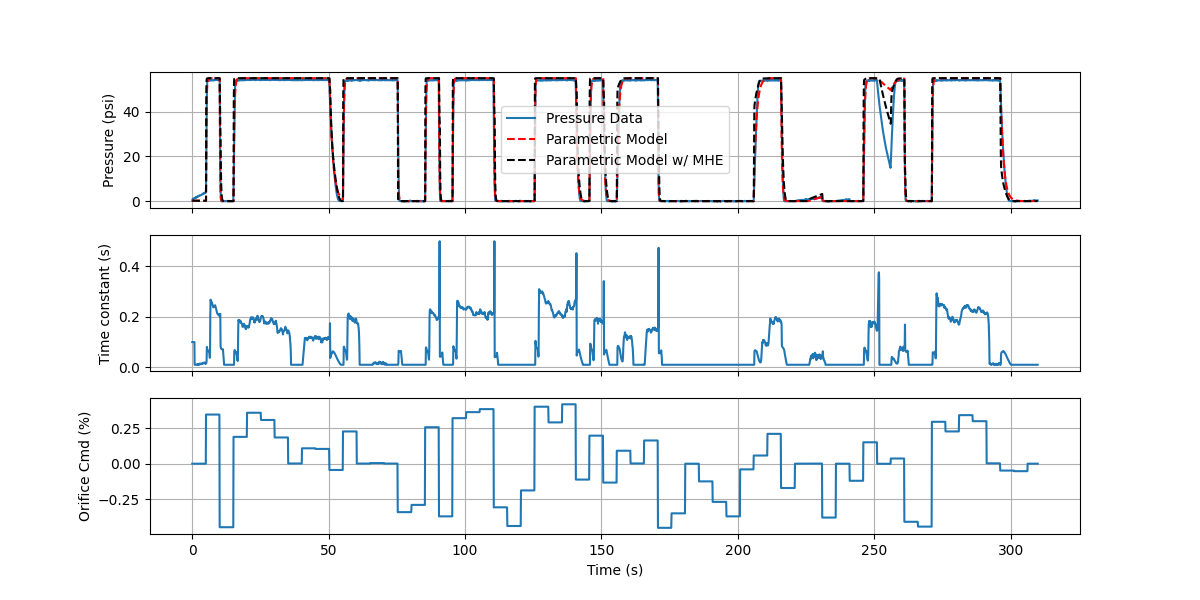

In [69]:
fig, ax = plt.subplots(3,1,sharex=True, figsize=(12,6))
ax[0].plot(time_data, pressure_data, label="Pressure Data")
ax[0].plot(time_data, psig(final_sim_pressure2), '--r', label="Parametric Model")
ax[0].plot(time_data, psig(p_hist), '--k', label="Parametric Model w/ MHE")
ax[0].legend().set_draggable(True)
ax[0].grid(True)
ax[0].set_ylabel('Pressure (psi)')

ax[1].plot(time_data, tau_hist, label='tau values')
ax[1].grid(True)
# ax[1].legend()
ax[1].set_ylabel('Time constant (s)')

ax[2].plot(time_data, area_cmds, label="Orifice Areas")
# ax[2].legend()
ax[2].grid(True)
ax[2].set_xlabel("Time (s)")
ax[2].set_ylabel('Orifice Cmd (%)')

plt.show()

In [70]:
plt.close('all')